### Данные - Ирисы Фишера

В задаче будет рассмотрена реальная выборка - ирисы Фишера, по 3 и 4 признаку, т.е. petalLength и petalWidth.

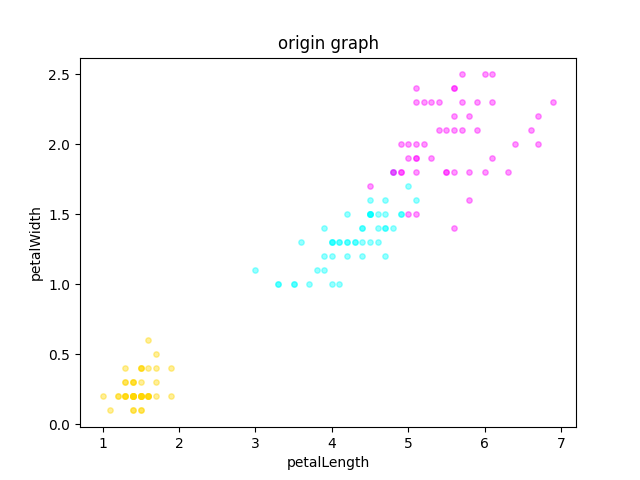


### Описание алгоритма

Определим понятие отступа для алгоритма классификации вида:

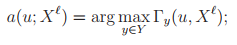

Тогда отступом объекта относительно алгоритма классификации назовем величину:

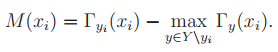

Смысл этой величины - типичность объекта для своего класса. Таким образом можно выделить 5 типов объектов:


*   Эталонные объекты - большой положительный отступ
*   Неинформативные объекты - небольшой положительный отступ. Понятие неинформативности задается из соображений вклада в качество классификации.
*   Пограничные объекты - объекты с отступом, близким к нулю
*   Ошибочные - небольшой отрицательный отступ
*   Шумовые (выбросы) - большой отрицательный отступ



Отбор шумовых объектов проводится на этапе предварительной обработки данных. Метод крутого склона позволяет удалить все объекты из выборки, отступ которых меньше некоторого наперед заданного числа. Остальные объекты уже могут быть отобраны только с использованием специальных алгоритмов, такик как STOLP.

На вход алгоритма поступает выборка, порог фильтрации выбросов и допустимая доля ошибок.
Шаги алгоритма:


1.   Отбросить шумовые объекты
2.   Выделить первые эталоны, как объекты с максимальным отступом для каждого класса
3.   Постепенно присоединять к множеству эталонных объектов, такие, которые входят в подмножество выборки без эталонов с отрицательным отступом, и дают на этом подможестве минимальный отступ. 


Таким образом сформируется множенство объектов, в котором для каждого класса будет один эталон и несколько приграничных объектов. 

### Код программы

Класс, отбирающий опорные объекты. Одно из полей класса это метод k взешенных ближайших соседей. 

In [ ]:
from knn_classes.abstract_neighbor_method import AbstractKNeighborsMethod as abstract_kNN


class STOLP:
    method: abstract_kNN

    delta: float
    l0: int

    objects_i: dict
    omega_i: dict

    current_margin: dict

    def __init__(self, method: abstract_kNN, delta, l0):
        self.method = method
        self.delta = delta
        self.l0 = l0
        self.cases_init()
        self.omega_init()

    def cases_init(self):
        cases = dict()
        for obj in self.method.objects:
            cases[obj[0]] = obj

        temp_cases = cases.copy()
        for key in cases:
            if self.margin(key, cases) < self.delta:
                del temp_cases[key]
        self.objects_i = temp_cases

    def omega_init(self):
        self.omega_i = dict()

        cases_by_classes = dict.fromkeys(self.method.answer_set)
        margins = dict()

        for key in cases_by_classes:
            cases_by_classes[key] = dict()
            margins[key] = (-1, None)

        for key in self.objects_i:
            x = self.method.objects[key]
            y = self.method.answers[x[0]]
            cases_by_classes[y][key] = x
        for key in cases_by_classes:
            for index in cases_by_classes[key]:
                margin = self.margin(index, self.objects_i)
                if margins[key][1] is None or margin > margins[key][1]:
                    margins[key] = (index, margin)
            self.omega_i[margins[key][0]] = self.method.objects[margins[key][0]]

    def omega_eq_cases(self):
        if len(self.omega_i) < len(self.objects_i):
            return False
        for key in self.objects_i:
            if key not in self.omega_i:
                return False
        return True

    def margin(self, i: int, cases: dict):
        obj = self.method.objects[i]
        answ = self.method.answers[obj[0]]
        gamma_by_classes = dict.fromkeys(self.method.answer_set)
        obj_neighbors = self.method.neighbors(obj, cases_dict=cases)

        for key in gamma_by_classes:
            gamma_by_classes[key] = self.method.gamma(key, obj, obj_neighbors)

        y_gamma = gamma_by_classes[answ]
        del gamma_by_classes[answ]
        max_gamma = max(gamma_by_classes.values())
        return y_gamma - max_gamma

    def error_indexes(self):
        self.current_margin = dict()
        error_indexes = []
        for i in self.objects_i:
            margin = self.margin(i, self.omega_i)
            self.current_margin[i] = margin
            if i not in self.omega_i and margin < 0:
                error_indexes.append(i)
        return error_indexes

    def arg_min_margin_index(self, error_indexes: list):
        arg_min_index = error_indexes[0]
        min_margin = self.current_margin[error_indexes[0]]
        for i in error_indexes:
            if self.current_margin[i] < min_margin:
                arg_min_index = self.method.objects[i][0]
                min_margin = self.current_margin[i]
        return arg_min_index

    def find_supporting_objects(self):
        i = 0
        while not self.omega_eq_cases():
            error_indexes = self.error_indexes()
            if len(error_indexes) < self.l0 or len(error_indexes) == 0:
                return self.get_cases_from_omega()
            arg_min_margin_index = self.arg_min_margin_index(error_indexes)
            print(i, self.omega_i)
            i += 1
            self.omega_i[arg_min_margin_index] = self.method.objects[arg_min_margin_index]

        return self.get_cases_from_omega()

    def get_cases_from_omega(self):
        cases = [[], [], []]
        i = 0
        for j in self.omega_i.keys():
            cases[0].append((i, self.method.objects[j][1]))
            cases[1].append(self.method.answers[j])
            cases[2].append((self.method.objects[j][1], self.method.answers[j]))
            i += 1
        return cases

### Результаты

Крупные точки и есть опорные объекты.

Для метода 6 ближайших соседей с единичными весами результат:

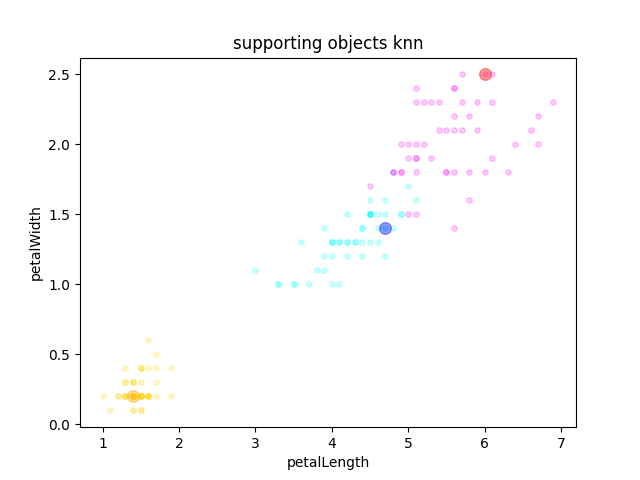

Проблемы отбора эталоных объектов связана с высокой вероятностью переобучения. Если, например, самый простой kNN дает неплохой результат (k=6, error=1/30), то если провести метод через STOLP, от выборки останется всего 3 объекта. Хотя они смогут без ошибок классифицировать обучающую выборку, но с новыми объектами, в особенности на границе красного и синего классов, будет большое количество ошибок.

Для метода 5 ближайших соседей с весами:

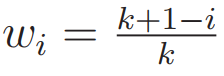

Результат:

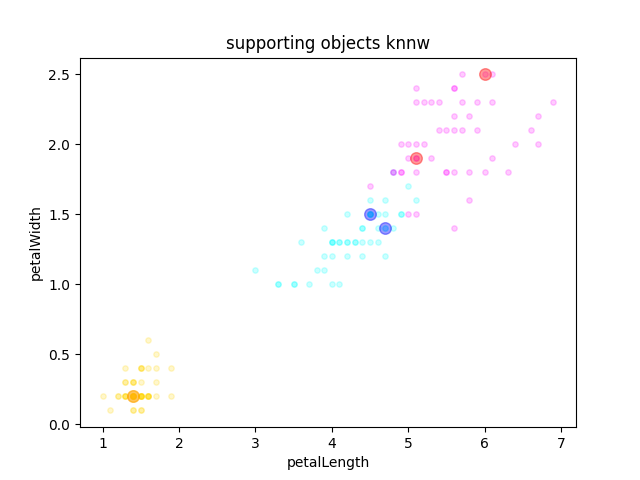

Для метода 6 ближайших соседей с геметрическими весами, где основание степени q = 0.9 :

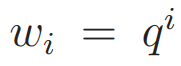

Результат:

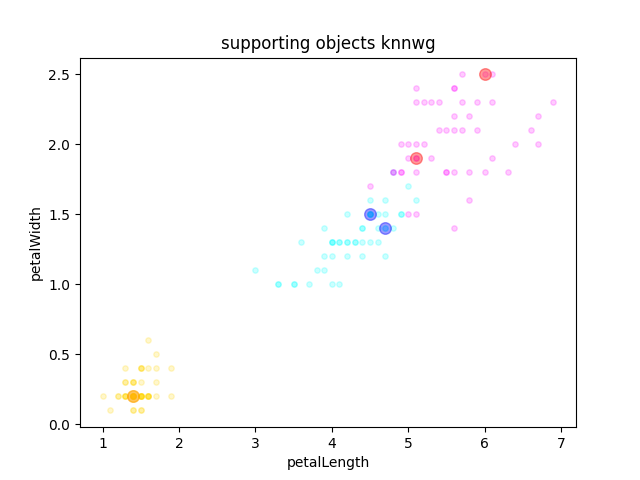